<h1>Imports and API setups<h1>

In [62]:
from __future__ import print_function    # (at top of module)
import warnings
#warnings.filterwarnings('always')
from spotipy.oauth2 import SpotifyClientCredentials
import json
import spotipy
import time
import sys
import csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
from matplotlib.pyplot import figure
import math
import seaborn as sns
import config


# Spotify API Setup
client_credentials_manager = SpotifyClientCredentials(config.client_id, config.client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Enables verbose requests tracing
sp.trace=False

## Read data from CSV

In [63]:
# Read the data from the file
data = pd.read_csv('data_600_entries.csv')
print("Number of entries in original data: " + str(len(data.index)))
data.head()

Number of entries in original data: 627


,song_id,song_title,artist,popularity,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration,loudness,valence,mode
0,spotify:track:01IQ4aQgOf0Kkq3a273hmO,Funky Friday,"[Dave, Fredo]",82,0.535,0.1070,125.066,0.1960,0.0783,0.000000,4,0.975,1,182741,-7.227,0.671,1
1,spotify:track:4iZC3zbvagtT4UbvuwH7fQ,Mia Khalifa,[iLOVEFRiDAY],71,0.517,0.3150,145.026,0.1130,0.2300,0.000000,4,0.817,1,177188,-9.613,0.541,1
2,spotify:track:2Y73798F4zbbbvKT02fbtE,Finalidade Era Ficar em Casa,[MC Kevin o Chris],77,0.978,0.0846,149.888,0.1980,0.5710,0.212000,4,0.810,6,185652,-3.949,0.703,1
3,spotify:track:5iwz1NiezX7WWjnCgY5TH4,Calma - Remix,"[Pedro Capó, Farruko]",79,0.773,0.1430,126.899,0.0524,0.3230,0.000000,4,0.826,11,238200,-4.218,0.761,0
4,spotify:track:4ej94zqr9xYLbWphCH3TcD,Beauty & Essex (feat. Daniel Caesar & Unknown ...,"[Free Nationals, Daniel Caesar, Unknown Mortal...",65,0.741,0.3340,69.709,0.0542,0.2840,0.000082,4,0.552,11,277046,-5.419,0.718,0


## Clean the data

In [64]:
if 'song_id' in data.columns:
    data = data.drop_duplicates(subset=['song_id'], keep='first')
else:
    data = data.drop_duplicates(subset=['song_title'], keep='first')
    
print("Number of entries in original data after cleaning: " + str(len(data.index)))

Number of entries in original data after cleaning: 607


In [65]:
data = data[data.popularity > 50]
print("Number of entries in original data after cleaning: " + str(len(data.index)))

Number of entries in original data after cleaning: 601


## Data wrangling

In [66]:
# Check if we have any null items in our data
data.isnull().sum()

song_id             0
song_title          0
artist              0
popularity          0
energy              0
liveness            0
tempo               0
speechiness         0
acousticness        0
instrumentalness    0
time_signature      0
danceability        0
key                 0
duration            0
loudness            0
valence             0
mode                0
dtype: int64

# START HERE

## Setting popularity threshold and adding lables to data

In [67]:
# Make a copy of the data to which we will ad labels and then remove any 
# columns that we will not need
# This is currently a duplicate of the functionality above - could maybe only do this in one place

final_data = data.copy()
threshold = 90
labels = []
labeled_popular = 0
labeled_notpopular = 0
for item in data['popularity']:
    if item > threshold:
        labels.append(1)
        labeled_popular = labeled_popular + 1
    else:
        labels.append(0)
        labeled_notpopular = labeled_notpopular + 1
final_data['is_popular'] = labels

print('Number of popular examples after thresholding : ', labeled_popular)
print('Number of not popular examples after thresholding : ', labeled_notpopular)

# Drop unnecessary columns from original data
if 'song_id' in data.columns:
    final_data.drop(['song_id', 'song_title', 'artist', 'popularity'], 1, inplace=True)
else:
    final_data.drop(['song_title', 'artist', 'popularity'], 1, inplace=True) 


Number of popular examples after thresholding :  47
Number of not popular examples after thresholding :  554


## Scale the data

c:\python27\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  from ipykernel import kernelapp as app


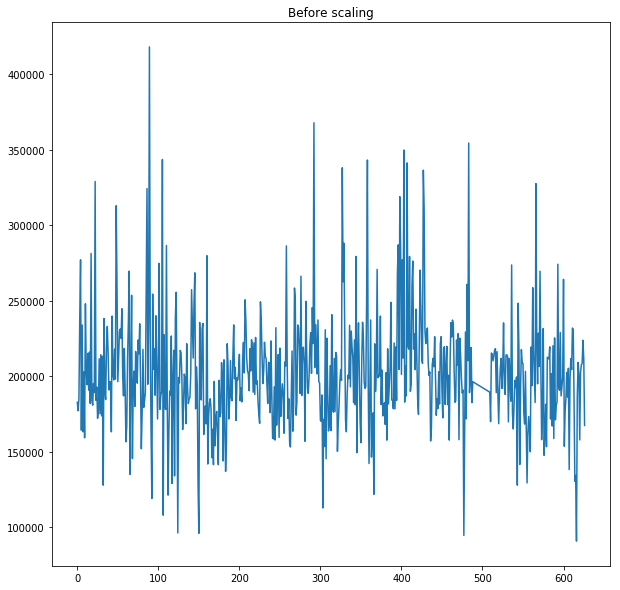

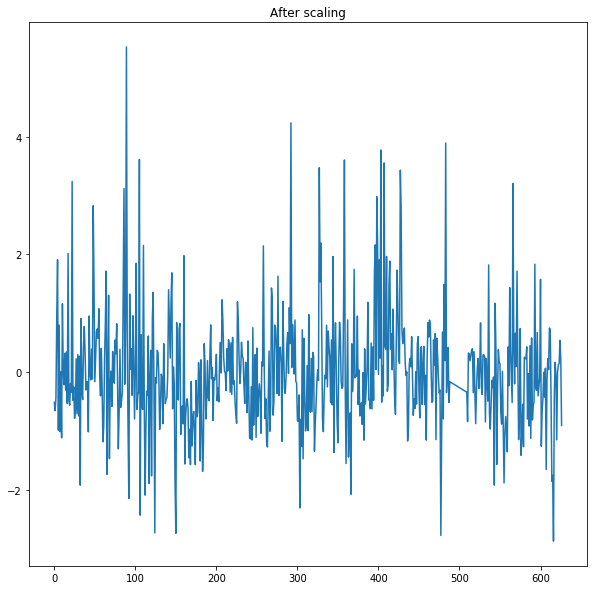

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration,loudness,valence,mode,is_popular
0,-0.770959,-0.454933,0.095538,0.631668,-0.743330,-0.147105,0.070248,2.096754,-1.171559,-0.509221,-0.551227,0.700227,0.864345,0
1,-0.883576,0.872502,0.775165,-0.149949,-0.079834,-0.147105,0.070248,0.885868,-1.171559,-0.651628,-1.647787,0.094637,0.864345,0
2,2.000668,-0.597887,0.940713,0.650502,1.411610,2.803299,0.070248,0.832221,0.219957,-0.434569,0.955279,0.849295,0.864345,0
3,0.718086,-0.225184,0.157951,-0.720624,0.326924,-0.147105,0.070248,0.954843,1.611472,0.913025,0.831652,1.119482,-1.156945,0
4,0.517878,0.993758,-1.789337,-0.703673,0.156348,-0.145964,0.070248,-1.145049,1.611472,1.909231,0.279695,0.919171,-1.156945,0


In [68]:
from sklearn.preprocessing import scale, MinMaxScaler

COLUMNS_TO_SCALE = ["energy", "liveness", "tempo", 
                    "speechiness", "acousticness", "instrumentalness", 
                    "time_signature", "danceability", "key", 
                    "duration", "loudness", "valence", "mode"]

# Keep data in a temp variable for testing
scaled_data = final_data.copy()

# Normalization
#scaled_data[COLUMNS_TO_SCALE] = MinMaxScaler().fit_transform(scaled_data[COLUMNS_TO_SCALE])

#Standardization
scaled_data[COLUMNS_TO_SCALE] = scale(scaled_data[COLUMNS_TO_SCALE])

# Plots to see the difference before/after scaling
plt.plot(final_data['duration'])
plt.title("Before scaling")
plt.show()

plt.plot(scaled_data['duration'])
plt.title("After scaling")
plt.show()

# Copy data back
final_data = scaled_data.copy()

#Just to check that everything is fine
final_data.head()

## Extract labels from data

In [69]:
# X will be our examples and y will be our labels
X = final_data.drop('is_popular', axis=1)
y = final_data['is_popular']
# Sanity checks
print("Number of entries in actual data: " + str(len(X.index)))
print("Number of entries in label data: " + str(len(y.index)))

Number of entries in actual data: 601
Number of entries in label data: 601


## Splitting data

In [70]:
# We split the data into training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=5)
print("Items in training data set : ", str(len(X_train.index)))
print("Items in testing data set: ", str(len(X_test.index)))

Items in training data set :  300
Items in testing data set:  301


## Model training and prediction

### Logistic Regression

In [98]:
# Initialize Logistic Regression Model
from sklearn.linear_model import LogisticRegression

# Can use the class_weight argument to assign different weights to the classes
# balanced - calculates the right weights according to the number of examples
# each class

logmodel = LogisticRegression(class_weight='balanced',random_state=3)
#logmodel = LogisticRegression(random_state=3)

print(logmodel)
# Train the model
logmodel.fit(X_train, y_train)

# Classifiy test examples
predictions = logmodel.predict(X_test)

# Print the accuracy score of the model
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictions)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=3,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


0.5714285714285714

In [99]:
# Calculate k-fold cross validation score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import SCORERS
classifier = LogisticRegression(class_weight='balanced',random_state=3)
# #print(sorted(SCORERS.keys()))
scores = cross_val_score(classifier, X, y, cv=10, scoring='accuracy')
print(scores)
print(scores.mean())

[ 0.67213115  0.68852459  0.73770492  0.70491803  0.68333333  0.56666667
  0.46666667  0.59322034  0.42372881  0.62711864]
0.61640131518


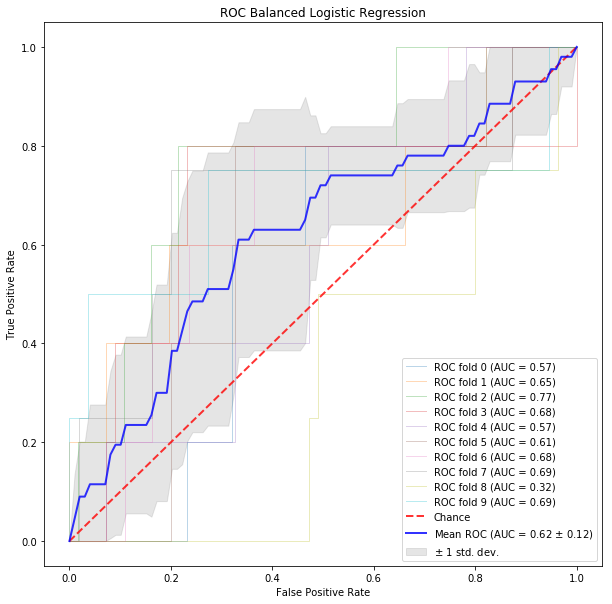

In [100]:
from sklearn import svm, datasets
from itertools import cycle
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)
classifier = LogisticRegression(random_state=3)
X = np.array(X)
y = np.array(y)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Balanced Logistic Regression with 10CV')
plt.legend(loc="lower right")
plt.show()

In [74]:
# Print the classification report of the model
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.93      0.58      0.71       277
           1       0.09      0.46      0.15        24

   micro avg       0.57      0.57      0.57       301
   macro avg       0.51      0.52      0.43       301
weighted avg       0.86      0.57      0.67       301



In [75]:
# # Print the confusion matrix
# from sklearn.metrics import confusion_matrix
# print(confusion_matrix(y_test, predictions))

[[161 116]
 [ 13  11]]


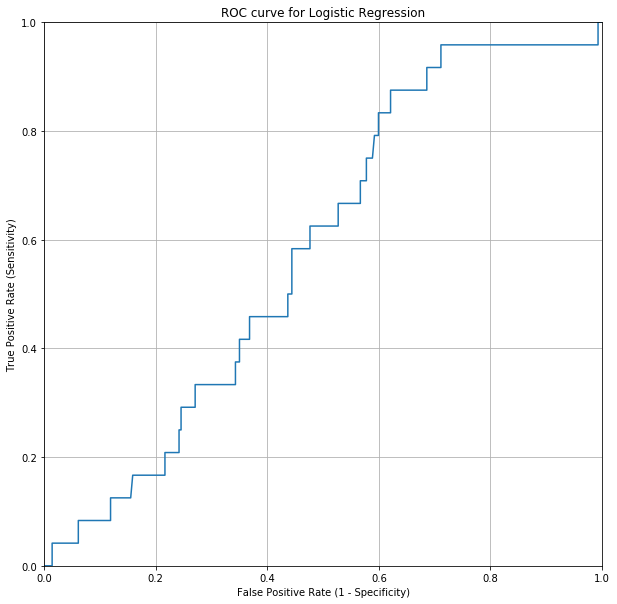

AUC score:  0.580776173285


In [76]:
# ROC curve
from sklearn.metrics import roc_curve
y_pred_prob = logmodel.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.plot([0,0],[1,1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Logistic Regression without 10CV')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.show()


# AUC score
from sklearn.metrics import roc_auc_score
print("AUC score: ", roc_auc_score(y_test, y_pred_prob))

## K Nearest Neighbours

In [77]:
from sklearn.neighbors import KNeighborsClassifier
nbrs = KNeighborsClassifier(n_neighbors = 14)

nbrs.fit(X_train, y_train)

# Classifiy test examples
predictionsKNN = nbrs.predict(X_test)
accuracy_score(y_test, predictionsKNN)

0.92026578073089704

In [78]:
# Looking for the best k value
k_range = list(range(1, 25))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)
print(max(k_scores))

[0.85833287024173388, 0.91342780401963508, 0.90006436973233295, 0.92020746503658424, 0.91690145410762247, 0.92187413170325105, 0.92187413170325105, 0.92187413170325105, 0.92187413170325105, 0.92187413170325105, 0.92187413170325105, 0.92187413170325105, 0.92187413170325105, 0.92187413170325105, 0.92187413170325105, 0.92187413170325105, 0.92187413170325105, 0.92187413170325105, 0.92187413170325105, 0.92187413170325105, 0.92187413170325105, 0.92187413170325105, 0.92187413170325105, 0.92187413170325105]
0.921874131703


Text(0,0.5,'Cross-Validated Accuracy')

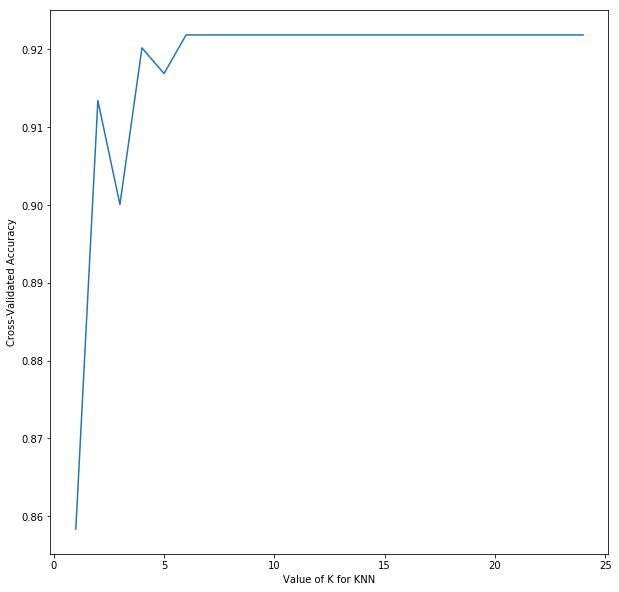

In [79]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

In [80]:
# Calculate k-fold cross validation score
from sklearn.model_selection import cross_val_score
classifier = KNeighborsClassifier(n_neighbors = 14)
scores = cross_val_score(nbrs, X, y, cv=10, scoring='accuracy')
print(scores)
print(scores.mean())

[ 0.91803279  0.91803279  0.91803279  0.91803279  0.91666667  0.91666667
  0.91666667  0.93220339  0.93220339  0.93220339]
0.921874131703


In [81]:
print(classification_report(y_test, predictionsKNN))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       277
           1       0.00      0.00      0.00        24

   micro avg       0.92      0.92      0.92       301
   macro avg       0.46      0.50      0.48       301
weighted avg       0.85      0.92      0.88       301



c:\python27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [82]:
confusion_matrix(y_test, predictionsKNN)

array([[277,   0],
       [ 24,   0]], dtype=int64)

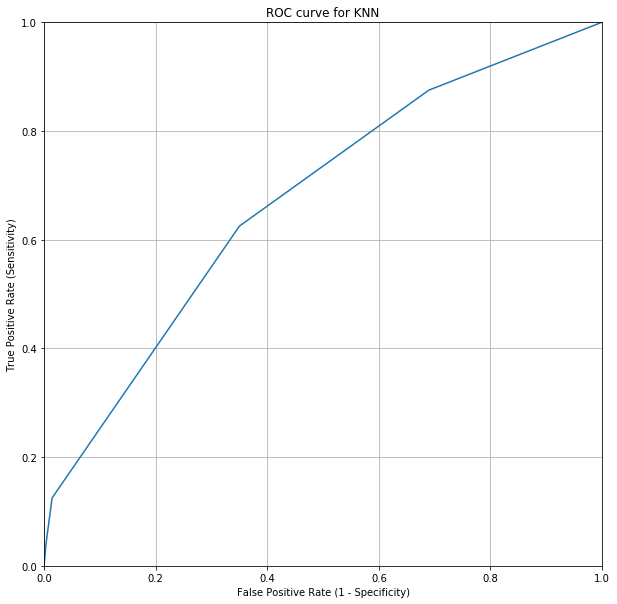

AUC score:  0.67245788207


In [83]:
# ROC curve
y_pred_prob_knn = nbrs.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_knn)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for KNN')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.show()


# AUC score
print("AUC score: ", roc_auc_score(y_test, y_pred_prob_knn))

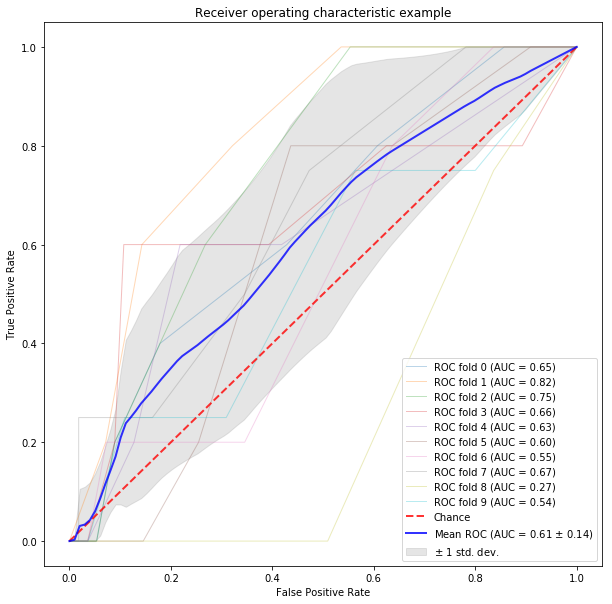

In [84]:
from sklearn import svm, datasets
from itertools import cycle
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)
classifier = KNeighborsClassifier(n_neighbors=k)
X = np.array(X)
y = np.array(y)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Below I will use over-sampling with SMOTE(Synthetic Minority Oversampling Technique) to make up for the lack of examples of popular songs. This is one approach to fix the imbalanced class problem.

# Over-sampling with SMOTE

### Imbalanced Logistic Regression

In [85]:
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
classifier = LogisticRegression()
smote_pipeline = make_pipeline_imb(SMOTE(), classifier)
smote_model = smote_pipeline.fit(X_train, y_train)
predictionsLogImb = smote_model.predict(X_test)

In [86]:
from collections import Counter
X_smote, y_smote = SMOTE().fit_sample(X, y)
print("Normal data distribution: ", Counter(y))
print("SMOTE data distribution: ", Counter(y_smote))

Normal data distribution:  Counter({0: 554, 1: 47})
SMOTE data distribution:  Counter({0: 554, 1: 554})


In [87]:
print(classification_report_imbalanced(y_test, predictionsLogImb))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.60      0.46      0.73      0.53      0.28       277
          1       0.09      0.46      0.60      0.15      0.53      0.27        24

avg / total       0.86      0.59      0.47      0.68      0.53      0.28       301



In [88]:
print(confusion_matrix(y_test, predictionsLogImb))

[[167 110]
 [ 13  11]]


In [89]:
accuracy_score(y_test, predictionsLogImb)

0.59136212624584716

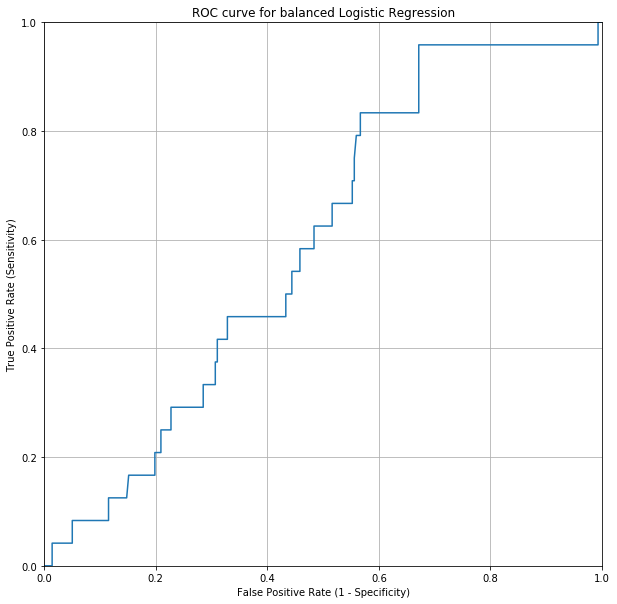

AUC score:  0.592809867629


In [90]:
# ROC curve
y_pred_prob_log_imb = smote_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_log_imb)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for balanced Logistic Regression')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.show()


# AUC score
print("AUC score: ", roc_auc_score(y_test, y_pred_prob_log_imb))

## Imbalanced KNN

In [91]:
classifierKNN = KNeighborsClassifier(n_neighbors = 14)
smote_pipeline_knn = make_pipeline_imb(SMOTE(), classifierKNN)
smote_model_knn = smote_pipeline_knn.fit(X_train, y_train)
predictionsKnnImb = smote_model_knn.predict(X_test)

In [92]:
print(classification_report_imbalanced(y_test, predictionsKnnImb))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.59      0.62      0.73      0.61      0.37       277
          1       0.12      0.62      0.59      0.20      0.61      0.37        24

avg / total       0.88      0.59      0.62      0.68      0.61      0.37       301



In [93]:
accuracy_score(y_test, predictionsKnnImb)

0.59136212624584716

In [94]:
print(confusion_matrix(y_test, predictionsKnnImb))

[[163 114]
 [  9  15]]


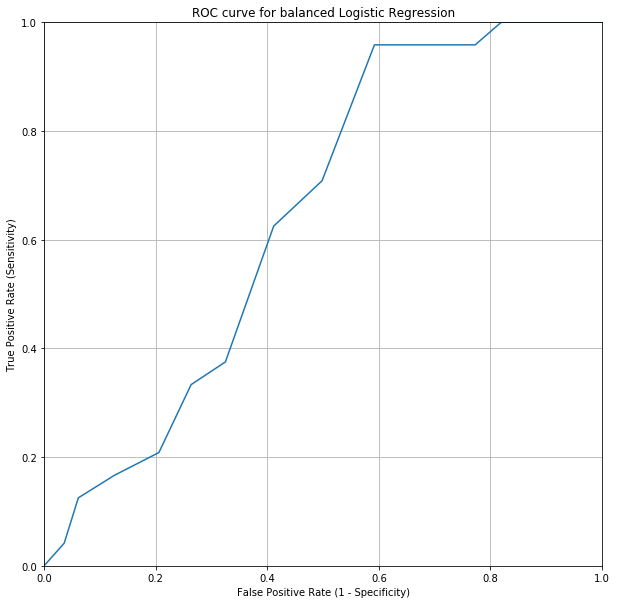

AUC score:  0.643351383875


In [95]:
# ROC curve
y_pred_prob_knn_imb = smote_model_knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_knn_imb)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for balanced Logistic Regression')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.show()


# AUC score
print("AUC score: ", roc_auc_score(y_test, y_pred_prob_knn_imb))

In [96]:
# cross validation done right
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
kf = StratifiedKFold(n_splits=10, random_state=42)
classifier = KNeighborsClassifier(n_neighbors = 14)
accuracy = []
precision = []
recall = []
f1 = []
auc = []
for train, test in kf.split(X, y):
    pipeline = make_pipeline_imb(SMOTE(), classifier)
    model = pipeline.fit(X[train], y[train])
    prediction = model.predict(X[test])
    prediction_proba = model.predict_proba(X[test])[:,1]
    
    accuracy.append(pipeline.score(X[test], y[test]))
    precision.append(precision_score(y[test], prediction))
    recall.append(recall_score(y[test], prediction))
    f1.append(f1_score(y[test], prediction))
    
    auc.append(roc_auc_score(y[test], prediction_proba))
    

In [97]:
print()
print("done right mean of scores 10-fold:")
print("accuracy: {}".format(np.mean(accuracy)))
print("precision: {}".format(np.mean(precision)))
print("recall: {}".format(np.mean(recall)))
print("f1: {}".format(np.mean(f1)))
print("auc: {}".format(np.mean(auc)))
print()
print(prediction_proba)


done right mean of scores 10-fold:
accuracy: 0.573666296193
precision: 0.0985727627868
recall: 0.535
f1: 0.165319701428
auc: 0.637795454545

[ 0.35714286  0.64285714  0.          0.5         0.          0.07142857
  0.14285714  0.28571429  0.28571429  0.          0.14285714  0.
  0.71428571  0.28571429  0.64285714  0.07142857  0.35714286  0.
  0.42857143  0.28571429  0.85714286  0.5         0.          0.14285714
  0.71428571  0.35714286  0.5         0.35714286  0.28571429  0.71428571
  0.71428571  0.35714286  1.          0.          0.92857143  0.42857143
  0.          0.5         0.5         0.42857143  0.          0.71428571
  0.78571429  0.14285714  0.28571429  0.64285714  0.64285714  0.78571429
  0.28571429  0.21428571  0.57142857  0.78571429  0.          0.5
  0.21428571  0.28571429  0.28571429  0.85714286  1.        ]
